Importing Libraries

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
 
import warnings
warnings.filterwarnings("ignore")

# Purple Theme 
%matplotlib inline
sns.set_theme(style="whitegrid", palette="Purples")
plt.rcParams["text.color"] = "#4b0082"

Notebook Goals
- EDA → restaurant locations, dish categories, pricing, ratings
- Visuals → top dishes, price distributions, rating trends, popular categories
- Baseline ML → Predict dish ratings or price (regression)

In [3]:
df = pd.read_csv("swiggy_all_menus_india.csv")
df.head()

,State,City,Restaurant Name,Location,Category,Dish Name,Price (INR),Rating,Rating Count
0,Karnataka,Bengaluru,Anand Sweets & Savouries,Rajarajeshwari Nagar,Snack,Butter Murukku-200gm,133.9,0.0,0
1,Karnataka,Bengaluru,Srinidhi Sagar Deluxe,Kengeri,Recommended,Badam Milk,52.0,4.5,25
2,Karnataka,Bengaluru,Srinidhi Sagar Deluxe,Kengeri,Recommended,Chow Chow Bath,117.0,4.7,48
3,Karnataka,Bengaluru,Srinidhi Sagar Deluxe,Kengeri,Recommended,Kesari Bath,65.0,4.6,65
4,Karnataka,Bengaluru,Srinidhi Sagar Deluxe,Kengeri,Recommended,Mix Raitha,130.0,0.0,0


### EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197430 entries, 0 to 197429
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   State            197430 non-null  object 
 1   City             197430 non-null  object 
 2   Restaurant Name  197430 non-null  object 
 3   Location         197430 non-null  object 
 4   Category         197430 non-null  object 
 5   Dish Name        197430 non-null  object 
 6   Price (INR)      197430 non-null  float64
 7   Rating           197430 non-null  float64
 8   Rating Count     197430 non-null  int64  
dtypes: float64(2), int64(1), object(6)
memory usage: 13.6+ MB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price (INR),197430.0,268.512920,219.338363,0.95,139.0,229.0,329.0,8000.0
Rating,197430.0,2.613625,2.145706,0.00,0.0,3.9,4.5,5.0
Rating Count,197430.0,28.321805,87.542593,0.00,0.0,2.0,15.0,999.0


In [6]:
df.shape

(197430, 9)

In [7]:
# Drop rows where Rating and Rating Count are both 0
df = df[~((df['Rating'] == 0) & (df['Rating Count'] == 0))]

df.shape

(119786, 9)

In [8]:
numcols = df.select_dtypes("number").columns.tolist()
catcols = df.select_dtypes("object").columns.tolist()
numcols, catcols

(['Price (INR)', 'Rating', 'Rating Count'],
 ['State', 'City', 'Restaurant Name', 'Location', 'Category', 'Dish Name'])

In [9]:
for col in catcols:
    print(f"Column : {col} \nDifferent values: {df[col].nunique()}\n")

Column : State 
Different values: 28

Column : City 
Different values: 28

Column : Restaurant Name 
Different values: 903

Column : Location 
Different values: 944

Column : Category 
Different values: 3934

Column : Dish Name 
Different values: 33629



### Data Visualization


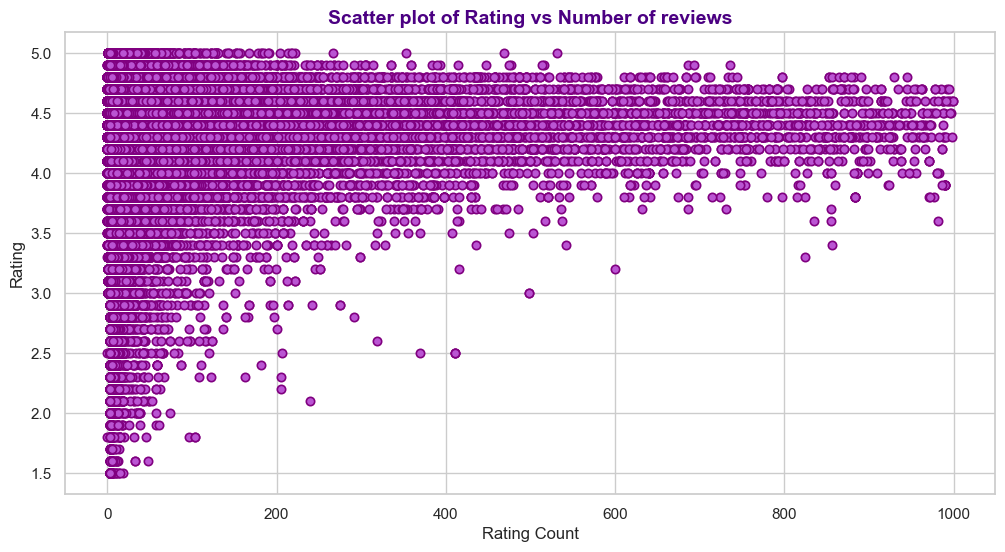

In [10]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=df, x="Rating Count", y="Rating", color="mediumorchid", edgecolor="purple", linewidth=1.2)
plt.title("Scatter plot of Rating vs Number of reviews", fontweight = "bold" , fontsize=14)
plt.show()

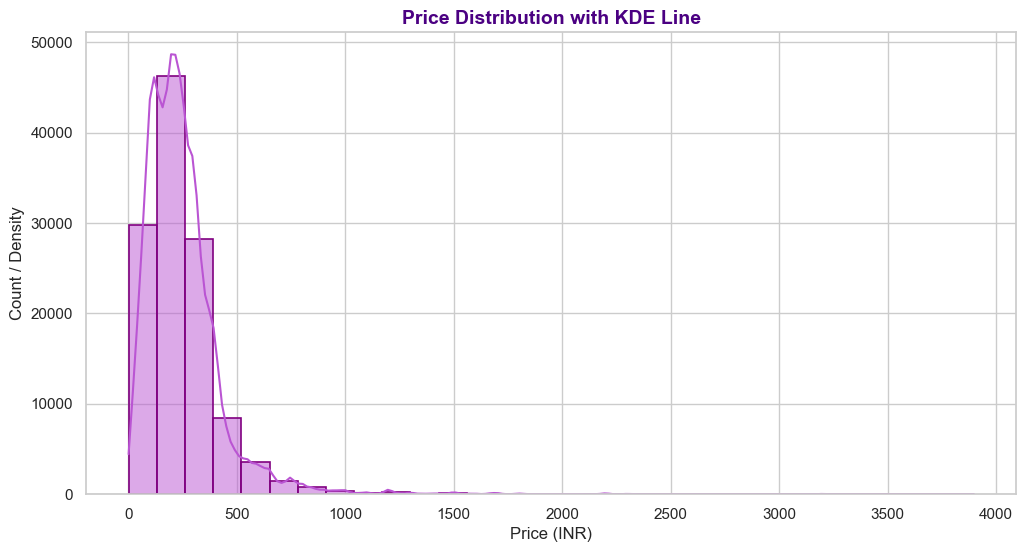

In [11]:
plt.figure(figsize=(12,6))
sns.histplot(df["Price (INR)"], bins=30, kde=True, color="mediumorchid", edgecolor="purple", linewidth=1.2)
plt.title("Price Distribution with KDE Line", fontweight = "bold" , fontsize=14)
plt.xlabel("Price (INR)")
plt.ylabel("Count / Density")
plt.show()

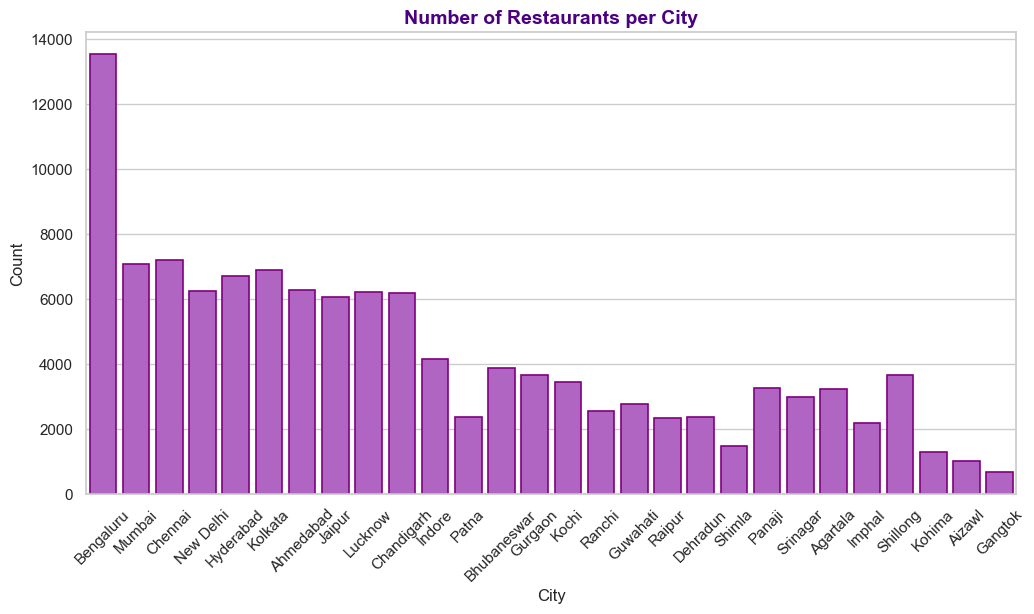

In [12]:
plt.figure(figsize=(12,6))
sns.countplot(data=df, x="City",
              color="mediumorchid",
              edgecolor="purple",
              linewidth=1.2)
plt.xticks(rotation=45)
plt.title("Number of Restaurants per City", fontsize=14, fontweight="bold")
plt.xlabel("City")
plt.ylabel("Count")
plt.show()

### Feature Engineering

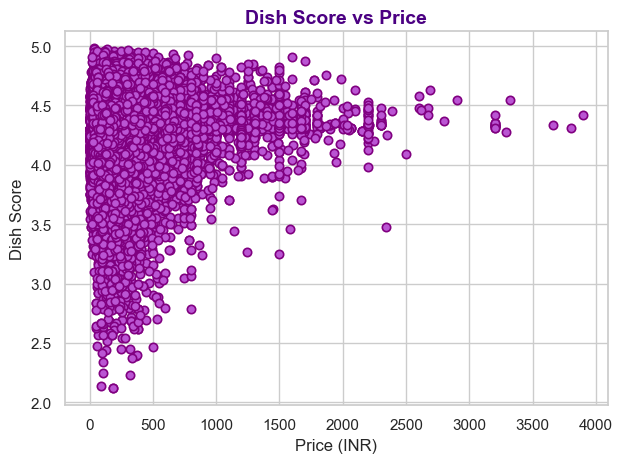

In [13]:
# High rating = good
# High number of reviews = more trustworthy

# m = minimum number of ratings to be “confident”
# Dishes with fewer than 15 ratings will be pulled toward the global average.
m = 15

# C = average rating across all dishes
C = df["Rating"].mean()

# Weighted score formula
df["Dish_Score"] = (df["Rating Count"] * df["Rating"] + m * C) / (df["Rating Count"] + m)

# Scatter plot of Dish_Score vs Price
sns.scatterplot(data=df, x="Price (INR)", y="Dish_Score", color="mediumorchid", edgecolor="purple", linewidth=1.2)
plt.title("Dish Score vs Price", fontweight="bold", fontsize=14)
plt.xlabel("Price (INR)")
plt.ylabel("Dish Score")

plt.tight_layout()
plt.show()

In [14]:
# Log transform of price
df["Log_Price"] = np.log1p(df["Price (INR)"])

# Dish name features
df["Dish_Name_Length"] = df["Dish Name"].str.len()
df["Dish_Name_Words"] = df["Dish Name"].str.split().str.len()

# Restaurant average price
df["Rest_Avg_Price"] = df.groupby("Restaurant Name")["Price (INR)"].transform("mean")
df["Price_vs_Rest_Avg"] = df["Price (INR)"] / df["Rest_Avg_Price"]

In [15]:
# Create binary target
df["High_Dish_Score"] = df["Dish_Score"].apply(lambda x: 1 if x > 4 else 0)

In [16]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
for col in catcols:
    df[col] = enc.fit_transform(df[col])

In [17]:
feature_cols = catcols + ["Log_Price", "Dish_Name_Words", "Price_vs_Rest_Avg"]
feature_cols

['State',
 'City',
 'Restaurant Name',
 'Location',
 'Category',
 'Dish Name',
 'Log_Price',
 'Dish_Name_Words',
 'Price_vs_Rest_Avg']

In [18]:
X = df[feature_cols]
y = df["High_Dish_Score"]

In [19]:
print(X.shape, y.shape)

(119786, 9) (119786,)


### Train Model

In [24]:
# -------------------------------
# Import required libraries
# -------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
import lightgbm as lgb

In [25]:
# -------------------------------
# Train/test split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=11)


In [26]:
# -------------------------------
# Model training
# -------------------------------

# ======= Models =======
models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": xgb.XGBClassifier(n_estimators=200, random_state=42, use_label_encoder=False, eval_metric="logloss"),
    "LightGBM": lgb.LGBMClassifier(n_estimators=200, random_state=42, verbose=-1),
    "Catboost": CatBoostClassifier(random_state=42, verbose=0)
}

# Train and evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"===== {name} =====")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\n")

===== RandomForest =====
Accuracy: 0.9209449870606895


===== XGBoost =====
Accuracy: 0.9229067534852659


===== LightGBM =====
Accuracy: 0.9218632607062359


===== Catboost =====
Accuracy: 0.9230737123299106


